# Appearance feature extraction with torchreid

In [1]:
%load_ext autoreload
%autoreload 2

To use the functionality demostrated in this notebook, you need to install torchreid. You can do this by running the following command:

In [2]:
from soccertrack.utils import get_git_root
root = get_git_root()

In [3]:
!git clone https://github.com/KaiyangZhou/deep-person-reid.git {root}/external/deep-person-reid
!pip install --quiet -r {root}/external/deep-person-reid/requirements.txt
!pip install --quiet -e {root}/external/deep-person-reid

fatal: destination path '/Users/atom/Github/SoccerTrack/external/deep-person-reid' already exists and is not an empty directory.


## An introduction to TorchReID

Torchreid is a deep learning library for person re-identification. It is built on top of PyTorch and provides a set of state-of-the-art person re-identification models, loss functions, datasets, and evaluation metrics. Torchreid is designed to be flexible and easy to use.

* Code: https://github.com/KaiyangZhou/deep-person-reid.
* Documentation: https://kaiyangzhou.github.io/deep-person-reid/.
* How-to instructions: https://kaiyangzhou.github.io/deep-person-reid/user_guide.
* Model zoo: https://kaiyangzhou.github.io/deep-person-reid/MODEL_ZOO.
* Tech report: https://arxiv.org/abs/1910.10093.

In this notebook, we will use Torchreid to extract appearance features from images. We will use the `FeatureExtractor` class since it is usable out of the box. To see what pretrained models are available, check out the [model zoo](https://kaiyangzhou.github.io/deep-person-reid/MODEL_ZOO) or use `soccertrack.image_model.show_torchreid_models()`.

In [4]:
from soccertrack.image_model import show_torchreid_models

print(show_torchreid_models())

['shufflenet', 'mobilenetv2_x1_0', 'mobilenetv2_x1_4', 'mlfn', 'osnet_x1_0', 'osnet_x0_75', 'osnet_x0_5', 'osnet_x0_25', 'osnet_ibn_x1_0', 'osnet_ain_x1_0', 'osnet_ain_x0_75', 'osnet_ain_x0_5', 'osnet_ain_x0_25', 'resnet50_MSMT17', 'osnet_x1_0_MSMT17', 'osnet_ain_x1_0_MSMT17']


## Using TorchReID Models to Extract Features

As documented in the [torchreid documentation](https://kaiyangzhou.github.io/deep-person-reid/user_guide/feature_extraction/), the `FeatureExtractor` class can be used to extract features from images.

```python
from torchreid.utils import FeatureExtractor

extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path='a/b/c/model.pth.tar',
    device='cuda'
)

image_list = [
    'a/b/c/image001.jpg',
    'a/b/c/image002.jpg',
    'a/b/c/image003.jpg',
    'a/b/c/image004.jpg',
    'a/b/c/image005.jpg'
]

features = extractor(image_list)
print(features.shape) # output (5, 512)
```

In SoccerTrack we have a wrapper around the `FeatureExtractor` class which automatically downloads the model if it is not available locally. The wrapper is called `soccertrack.image_model.TorchReIDModel`.

In [5]:
from soccertrack.image_model import TorchReIDModel

extractor = TorchReIDModel(model_name="osnet_ain_x1_0_MSMT17", device="cpu", image_size=(32, 32))

download_model:0044  💬| Model osnet_ain_x1_0_MSMT17 already exists in /Users/atom/Github/SoccerTrack/models/torchreid. 
__init__:0078  💬| /Users/atom/Github/SoccerTrack/models/torchreid/osnet_ain_x1_0_MSMT17.pth 
Model: osnet_ain_x1_0
- params: 2,193,616
- flops: 30,875,536
Successfully loaded pretrained weights from "/Users/atom/Github/SoccerTrack/models/torchreid/osnet_ain_x1_0_MSMT17.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [6]:
from pathlib import Path

dataset_root = Path(root) / "data" / "appearance_extractor" / "testset"
_image_paths = sorted(dataset_root.glob("**/*.png"))

image_paths = [str(p) for p in _image_paths]
labels = [int(p.parent.name) for p in _image_paths]

print(f"n_images: {len(_image_paths)}")
print(f"n_labels: {len(labels)}, n_classes: {len(set(labels))}")

embeddings = extractor(image_paths)
print(f"embeddings.shape: {embeddings.shape}")

n_images: 3300
n_labels: 3300, n_classes: 2
embeddings.shape: torch.Size([3300, 512])


## Visualize embeddings with t-SNE

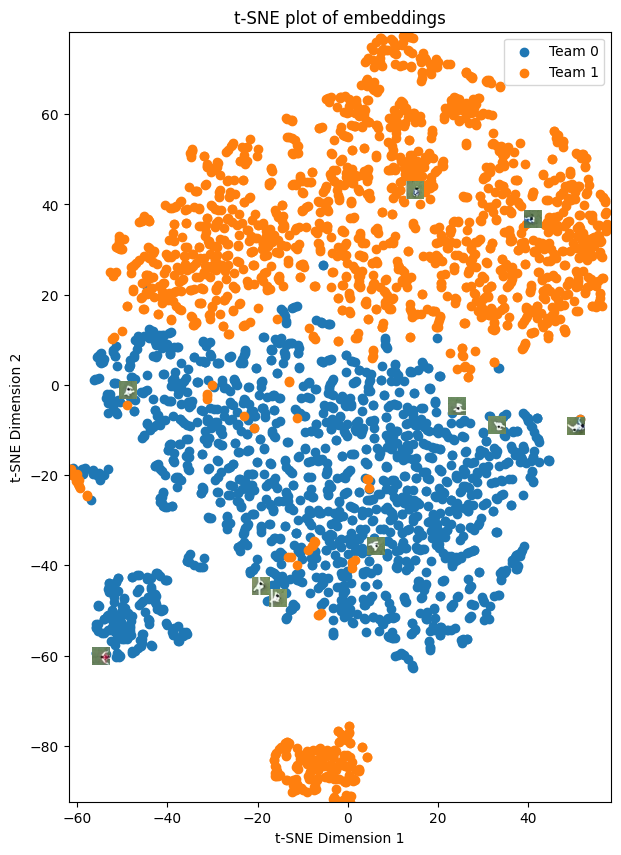

In [7]:
from soccertrack.image_model import plot_tsne

plot_tsne(embeddings, labels, image_paths)

## Comparing various models

Here we will train an svm classifier on the extracted features and compare the performance of different models. 

In [12]:
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from soccertrack.logger import set_log_level

def evaluate_model(model_name):
    extractor = TorchReIDModel(model_name=model_name, device="cpu", image_size=(32, 32), verbose=False)
    
    dataset_root = Path(root) / "data" / "appearance_extractor" 

    _train_image_paths = sorted((dataset_root / "trainset").glob("**/*.png"))
    train_image_paths = [str(p) for p in _train_image_paths]
    train_labels = np.array([int(p.parent.name) for p in _train_image_paths])

    _test_image_paths = sorted((dataset_root / "testset").glob("**/*.png"))
    test_image_paths = [str(p) for p in _test_image_paths]
    test_labels = np.array([int(p.parent.name) for p in _test_image_paths])

    train_embeddings = extractor(train_image_paths)
    test_embeddings = extractor(test_image_paths)

    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(train_embeddings, train_labels)

    score = clf.score(test_embeddings, test_labels)
    return score

set_log_level('WARNING') # Quiet down the logger

model_name = "shufflenet"
print(f"Score for {model_name}: {evaluate_model(model_name)}")

Score for shufflenet: 0.9784848484848485


In [ ]:
import time

score_results = {}
for model_name in show_torchreid_models():
    if model_name in score_results:
        continue
    
    try:
        start = time.time()
        score = evaluate_model(model_name)
        print(f"Score for {model_name}: {score} (took {time.time() - start:.2f}s)")
    except:
        print(f"Failed to evaluate {model_name}! Skipping...")
        score = None
    
    score_results[model_name] = score

Score for shufflenet: 0.9784848484848485 (took 61.04s)
Score for mobilenetv2_x1_0: 0.8709090909090909 (took 158.22s)
Score for mobilenetv2_x1_4: 0.9372727272727273 (took 199.91s)
Failed to evaluate mlfn! Skipping...
Score for osnet_x1_0: 0.9760606060606061 (took 62.41s)
Score for osnet_x0_75: 0.9587878787878787 (took 50.11s)
Score for osnet_x0_5: 0.9563636363636364 (took 40.50s)
Score for osnet_x0_25: 0.9584848484848485 (took 29.00s)
Score for osnet_ibn_x1_0: 0.9518181818181818 (took 68.32s)
Score for osnet_ain_x1_0: 0.9409090909090909 (took 68.50s)
Score for osnet_ain_x0_75: 0.9415151515151515 (took 55.57s)
Score for osnet_ain_x0_5: 0.9463636363636364 (took 41.15s)
Score for osnet_ain_x0_25: 0.9212121212121213 (took 37.54s)
Failed to evaluate resnet50_MSMT17! Skipping...
Score for osnet_x1_0_MSMT17: 0.9763636363636363 (took 58.06s)
Score for osnet_ain_x1_0_MSMT17: 0.980909090909091 (took 57.92s)
